In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
from PIL import Image
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
import cv2
import scipy.misc
from skimage import transform
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from skimage.transform import resize
from keras.models import Model

import warnings
warnings.filterwarnings("ignore")


batch_size =128
epochs = 10

In [0]:
import os
total_data_path = '/content/drive/My Drive/computervision_assignment2/train.zip (Unzipped Files)/'
train_path ='/content/drive/My Drive/computervision_assignment2/train.zip (Unzipped Files)/train/'
test_path = '/content/drive/My Drive/computervision_assignment2/test.zip (Unzipped Files)/test/'
labels_path ='/content/drive/My Drive/computervision_assignment2/labels.csv.zip (Unzipped Files)/labels.csv'

In [0]:
from zipfile import ZipFile
with ZipFile("/content/drive/My Drive/computervision_assignment2/test.zip","r") as z:
  z.extractall()

  # zip file extraction for the test dataset


from zipfile import ZipFile 
with ZipFile('/content/drive/My Drive/computervision_assignment2/train.zip','r') as z:
  z.extractall()

  # Zip file extraction for the train dataset

from zipfile import ZipFile 
with ZipFile('/content/drive/My Drive/computervision_assignment2/labels.csv.zip','r') as z:
  z.extractall()

  # Label zip file extraction 


from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/computervision_assignment2/sample_submission.csv.zip','r') as z:
  z.extractall()


In [0]:
labels = pd.read_csv('labels.csv')
labels.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [0]:
labels['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

In [0]:
labels['breed'].nunique()

120

In [0]:
labels['breed'].unique()

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

In [0]:
list(labels['breed'].value_counts().head(20).index)

['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog',
 'shih-tzu',
 'pomeranian',
 'great_pyrenees',
 'basenji',
 'samoyed',
 'airedale',
 'tibetan_terrier',
 'cairn',
 'leonberg',
 'japanese_spaniel',
 'beagle',
 'australian_terrier',
 'miniature_pinscher',
 'blenheim_spaniel',
 'irish_wolfhound']

In [0]:
list(labels['breed'].value_counts().head(20))

[126,
 117,
 116,
 115,
 114,
 112,
 111,
 111,
 110,
 109,
 107,
 107,
 106,
 106,
 105,
 105,
 102,
 102,
 102,
 101]

In [0]:
top_20_breeds = list(labels['breed'].value_counts().head(20).index)
labels.breed.isin(top_20_breeds)

0        False
1        False
2        False
3        False
4        False
         ...  
10217    False
10218    False
10219     True
10220     True
10221    False
Name: breed, Length: 10222, dtype: bool

In [0]:
labels_20_breed=labels[labels.breed.isin(top_20_breeds)]

In [0]:
len(labels_20_breed)

2184

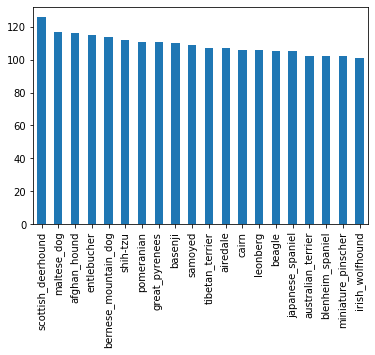

In [0]:
plot_for_20_breed=labels_20_breed['breed'].value_counts()
plot_for_20_breed.plot(kind= 'bar')

In [0]:
# import matplotlib.pyplot
# matplotlib.pyplot.bar(labels_20_breed['breed'],height = 100,orientation = 'horizontal')

Get one hot Encoded for labels

In [0]:
# y(label) value should be one hot enocoded for fit 

dog_type = (labels['breed'])

dog_type_hot_coded = pd.get_dummies(dog_type)
#type(dog_type_hot_coded)
dog_type_hot_coded_array = np.asarray(dog_type_hot_coded)

## Preparing training dataset
1. Write a code which reads each and every id from labels.csv file and loads the corresponding image (in RGB - 128, 128, 3) from the train folder. <br>
2. Create 2 variables <br> 
     a.  x_train - Should have all the images of the dogs from train folder <br>
     b.  y_train - Corresponding label of the dog <br>
<u>Note:</u> The id of the dog images and its corresponding labels are available in labels.csv file   
<u>Hint:</u> Watch the video shared on "Preparing the training dataset" if you face issue on creating the training dataset

In [0]:
labels.values

array([['000bec180eb18c7604dcecc8fe0dba07', 'boston_bull'],
       ['001513dfcb2ffafc82cccf4d8bbaba97', 'dingo'],
       ['001cdf01b096e06d78e9e5112d419397', 'pekinese'],
       ...,
       ['ffe2ca6c940cddfee68fa3cc6c63213f', 'airedale'],
       ['ffe5f6d8e2bff356e9482a80a6e29aac', 'miniature_pinscher'],
       ['fff43b07992508bc822f33d8ffd902ae', 'chesapeake_bay_retriever']],
      dtype=object)

In [0]:
y_train_data = []
X_train_data = []
i=0
for image,breed in tqdm(labels.values):
  
  img = cv2.imread('./train/{}.jpg'.format(image))
  label = dog_type_hot_coded_array[i]
  X_train_data.append(cv2.resize(img,(128,128)))
  y_train_data.append(label)
  i+=1


100%|██████████| 10222/10222 [00:28<00:00, 354.11it/s]


In [0]:
import pickle
pickle_out = open('/content/drive/My Drive/computervision_assignment2/train.zip (Unzipped Files)/train/x_train_data.pickle','wb')
pickle.dump(X_train_data,pickle_out)
pickle_out.close()

pickle_out = open('/content/drive/My Drive/computervision_assignment2/test.zip (Unzipped Files)/test/y_test_data.pickle','wb')
pickle.dump(y_train_data,pickle_out)
pickle_out.close()



# Pickle module implements  binary protocal for deserialization and serialization  of Python Objects
# Serialization(Pickling) : Converting the python object into byte stream
# Deserialization(Unpickling) : Inverse of the above

##Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model

In [0]:
# Normalizing the training data requires the X_train_data
#X_train_data    # Their values ranges from 0 to 255
# X_train_data = X_train_data.astype(int)/255
  
y_train_data = np.array(y_train_data)                             # Already one hot encoded, hence normalization is not needed
X_train_data = np.array(X_train_data)
X_train_data = X_train_data/255

# print(X_train_data)                                             # Their values are between 0 to 1 
# print(X_train_data.shape)                                       # The shape is found to be (10222, 128, 128, 3)

### Split the training and validation data from `x_train_data` and `y_train_data` obtained from above step

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X_train_data,y_train_data,test_size=0.30, random_state =5) 

In [0]:
X_train.shape

(7155, 128, 128, 3)

In [0]:
X_test.shape

(3067, 128, 128, 3)

In [0]:
y_train.shape


(7155, 120)

In [0]:
y_train.shape

(7155, 120)

### Loading the test data
Read the id column from the samples_submission.csv and store it in test_img

In [0]:
test_data = pd.read_csv('sample_submission.csv')
# test_data

test_img = test_data['id']
test_img.head(10)

0    000621fb3cbb32d8935728e48679680e
1    00102ee9d8eb90812350685311fe5890
2    0012a730dfa437f5f3613fb75efcd4ce
3    001510bc8570bbeee98c8d80c8a95ec1
4    001a5f3114548acdefa3d4da05474c2e
5    00225dcd3e4d2410dd53239f95c0352f
6    002c2a3117c2193b4d26400ce431eebd
7    002c58d413a521ae8d1a5daeb35fc803
8    002f80396f1e3db687c5932d7978b196
9    0036c6bcec6031be9e62a257b1c3c442
Name: id, dtype: object

In [0]:
#y_train_data = []
X_test_data = []
i=0
for image in tqdm(test_img.values):
  
  img = cv2.imread('./test/{}.jpg'.format(image))
  # label = dog_type_hot_coded_array[i]
  X_test_data.append(cv2.resize(img,(128,128)))
  # y_train_data.append(label)
  # i+=1


100%|██████████| 10357/10357 [00:29<00:00, 345.58it/s]


#Normalize the test data and convert it into 4 dimensions

In [0]:
X_test_data = np.array(X_test)
X_test_data = X_test_data/255

### Build a basic conv neural network with 2 conv layers (kernel sizes - 5 and 3) add layers as mentioned below for classification.

1. Add a Dense layer with 256 neurons with `relu` activation

2. Add a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [0]:
#from tf.keras.models import Sequential
input_shape = (128,128,3)                                                          # Height, width and channel
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32,kernel_size=5,input_shape = input_shape,activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64,kernel_size=3,activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
model.add(tf.keras.layers.Flatten())                                                 # Flattening for applying the input to the Dense layers
model.add(tf.keras.layers.Dense(256,activation = 'relu'))
model.add(tf.keras.layers.Dense(120,activation = 'softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 124, 124, 32)      2432      
_________________________________________________________________
batch_normalization_3 (Batch (None, 124, 124, 32)      128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 238144)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               60965120  
_________________________________________________________________
dense_14 (Dense)             (None, 120)              

### Use batch_size = 128 and epochs = 10 and execute the model

In [0]:
batch_size = 128
epochs = 10
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-6),loss = 'categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train, validation_data= [X_test_data,y_test], batch_size= batch_size , epochs= epochs)

Train on 7155 samples, validate on 3067 samples
Epoch 1/10
7155/7155 [==============================] - 7s 975us/sample - loss: 4.8229 - accuracy: 0.0119 - val_loss: 4.7875 - val_accuracy: 0.0078
Epoch 2/10
7155/7155 [==============================] - 6s 891us/sample - loss: 4.7276 - accuracy: 0.0224 - val_loss: 4.7881 - val_accuracy: 0.0091
Epoch 3/10
7155/7155 [==============================] - 6s 896us/sample - loss: 4.6664 - accuracy: 0.0296 - val_loss: 4.7919 - val_accuracy: 0.0101
Epoch 4/10
7155/7155 [==============================] - 6s 890us/sample - loss: 4.6025 - accuracy: 0.0396 - val_loss: 4.8026 - val_accuracy: 0.0101
Epoch 5/10
7155/7155 [==============================] - 6s 891us/sample - loss: 4.5330 - accuracy: 0.0509 - val_loss: 4.8213 - val_accuracy: 0.0108
Epoch 6/10
7155/7155 [==============================] - 6s 889us/sample - loss: 4.4624 - accuracy: 0.0604 - val_loss: 4.8515 - val_accuracy: 0.0121
Epoch 7/10
7155/7155 [==============================] - 6s 890us

#The model accuracy is very poor !!!!
### Use Data Augmentation in the above model to see if the accuracy improves

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
train_data_generator = ImageDataGenerator(rotation_range = 5,zoom_range =0.2,
                                          horizontal_flip =False, fill_mode)

In [0]:
validation_data_generator = ImageDataGenerator(rotation_range = 5,zoom_range =0.2,
                                          horizontal_flip =False, fill_mode = 'nearest')

### Using the above objects, create the image generators with variable names `train_generator` and `val_generator`

You need to use train_datagen.flow() and val_datagen.flow()

In [0]:
train_generator = train_data_generator.flow(X_train,y_train)
val_generator        = validation_data_generator.flow(X_test_data,y_test)

### Fit the model using fit_generator() using `train_generator` and `val_generator` from the above step with 10 epochs

In [0]:
model.fit_generator(train_generator,validation_data = val_generator ,verbose = 1, epochs=10 )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 224 steps, validate for 96 steps
Epoch 1/10
224/224 [==============================] - 33s 146ms/step - loss: 4.4223 - accuracy: 0.0591 - val_loss: 5.2211 - val_accuracy: 0.0108
Epoch 2/10
224/224 [==============================] - 31s 140ms/step - loss: 4.3199 - accuracy: 0.0783 - val_loss: 5.2713 - val_accuracy: 0.0101
Epoch 3/10
224/224 [==============================] - 32s 144ms/step - loss: 4.2484 - accuracy: 0.0900 - val_loss: 5.3130 - val_accuracy: 0.0101
Epoch 4/10
224/224 [==============================] - 32s 144ms/step - loss: 4.1834 - accuracy: 0.0980 - val_loss: 5.4202 - val_accuracy: 0.0101
Epoch 5/10
224/224 [==============================] - 32s 142ms/step - loss: 4.1270 - accuracy: 0.1041 - val_loss: 5.4788 - val_accuracy: 0.0101
Epoch 6/10
224/224 [==============================] - 31s 139ms/step - loss: 4.0649 - accuracy: 0.1185 - val_loss: 5.5127 - val_accuracy: 0.0108
Epoch 7/10
224/224 [=================

# Model accuracy is still poor!!!

### Lets use Transfer Learning

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

Use the below code to load VGG16 weights trained on ImageNet

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input


project_path  = '/content/drive/My Drive/computervision_assignment2/'

# Instantiate the model with the pre-trained weights (no top)
base_model= tf.keras.applications.VGG16(weights=(project_path+'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),
                 include_top=False, pooling='avg')

Print the summary of the base_model

In [0]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Add the following classification layers to the imported VGG Model <br>
1. Flatten Layer
2. Dense layer with 1024 neurons with activation as Relu
3. Dense layer with 256 neurons with activation as Relu
4. Dense layer with 120 neurons with activation as Softmax

In [0]:
# base_model.add(tf.keras.layers.Flatten()) 
# base_model.add(tf.keras.layers.Dense(1024,activation = 'relu'))
# base_model.add(tf.keras.layers.Dense(256,activation = 'relu'))
# base_model.add(tf.keras.layers.Dense(120,activation = 'softmax'))
# model.summary()

### Make all the layers in the base_model (VGG16) to be non-trainable

In [0]:
base_model.trainable = False
# 
model1 = tf.keras.models.Sequential()
model1.add(base_model)
model1.add(tf.keras.layers.Dense(1024,activation = 'relu'))
model1.add(tf.keras.layers.Dense(256,activation = 'relu'))
model1.add(tf.keras.layers.Dense(120,activation = 'softmax'))
model1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_16 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_17 (Dense)             (None, 120)               30840     
Total params: 15,533,240
Trainable params: 818,552
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
batch_size = 128
epochs = 10
model1.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-6),loss = 'categorical_crossentropy',metrics=['accuracy'])
model1.fit(X_train,y_train, validation_data= [X_test_data,y_test], batch_size= batch_size , epochs= epochs)

Train on 7155 samples, validate on 3067 samples
Epoch 1/10
7155/7155 [==============================] - 9s 1ms/sample - loss: 4.8402 - accuracy: 0.0075 - val_loss: 4.8312 - val_accuracy: 0.0065
Epoch 2/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 4.8371 - accuracy: 0.0075 - val_loss: 4.8296 - val_accuracy: 0.0065
Epoch 3/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 4.8342 - accuracy: 0.0078 - val_loss: 4.8281 - val_accuracy: 0.0065
Epoch 4/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 4.8315 - accuracy: 0.0075 - val_loss: 4.8266 - val_accuracy: 0.0065
Epoch 5/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 4.8289 - accuracy: 0.0075 - val_loss: 4.8252 - val_accuracy: 0.0065
Epoch 6/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 4.8264 - accuracy: 0.0074 - val_loss: 4.8239 - val_accuracy: 0.0065
Epoch 7/10
7155/7155 [==============================] - 8s 1ms/sample - loss

In [0]:
#Changing the optimizers

In [0]:
batch_size = 128
epochs = 10
model1.compile(optimizer= 'rmsprop',loss = 'categorical_crossentropy',metrics=['accuracy'])
model1.fit(X_train,y_train, validation_data= [X_test_data,y_test], batch_size= batch_size , epochs= epochs)

Train on 7155 samples, validate on 3067 samples
Epoch 1/10
7155/7155 [==============================] - 9s 1ms/sample - loss: 4.7127 - accuracy: 0.0246 - val_loss: 4.8487 - val_accuracy: 0.0098
Epoch 2/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 4.2680 - accuracy: 0.0700 - val_loss: 4.9633 - val_accuracy: 0.0059
Epoch 3/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 3.8585 - accuracy: 0.1242 - val_loss: 5.1534 - val_accuracy: 0.0075
Epoch 4/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 3.5774 - accuracy: 0.1645 - val_loss: 5.3385 - val_accuracy: 0.0085
Epoch 5/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 3.3605 - accuracy: 0.1980 - val_loss: 5.3911 - val_accuracy: 0.0052
Epoch 6/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 3.1924 - accuracy: 0.2288 - val_loss: 5.3307 - val_accuracy: 0.0108
Epoch 7/10
7155/7155 [==============================] - 8s 1ms/sample - loss

In [0]:
base_model.trainable = False
# 
model2 = tf.keras.models.Sequential()
model2.add(base_model)
model2.add(tf.keras.layers.Dense(1024,activation = 'relu'))
model2.add(tf.keras.layers.Dense(256,activation = 'relu'))
model2.add(tf.keras.layers.Dense(120,activation = 'sigmoid'))
model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_19 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_20 (Dense)             (None, 120)               30840     
Total params: 15,533,240
Trainable params: 818,552
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
batch_size = 128
epochs = 10
model2.compile(optimizer= 'rmsprop',loss = 'categorical_crossentropy',metrics=['accuracy'])
model2.fit(X_train,y_train, validation_data= [X_test_data,y_test], batch_size= batch_size , epochs= epochs)

Train on 7155 samples, validate on 3067 samples
Epoch 1/10
7155/7155 [==============================] - 9s 1ms/sample - loss: 4.7433 - accuracy: 0.0182 - val_loss: 4.8345 - val_accuracy: 0.0108
Epoch 2/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 4.3560 - accuracy: 0.0584 - val_loss: 4.9687 - val_accuracy: 0.0095
Epoch 3/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 3.9203 - accuracy: 0.1054 - val_loss: 5.1019 - val_accuracy: 0.0075
Epoch 4/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 3.6189 - accuracy: 0.1469 - val_loss: 5.2620 - val_accuracy: 0.0075
Epoch 5/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 3.3909 - accuracy: 0.1905 - val_loss: 5.3162 - val_accuracy: 0.0075
Epoch 6/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 3.2244 - accuracy: 0.2173 - val_loss: 5.2948 - val_accuracy: 0.0108
Epoch 7/10
7155/7155 [==============================] - 8s 1ms/sample - loss